In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [6]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

from langchain_ollama import ChatOllama
# from langchain_mistralai import ChatMistralAI
# Summarization model 
summarization_model = ChatOllama(model="qwen3:8b", temperature=0.0)
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [7]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos
from langchain_ollama import ChatOllama
# from langchain_mistralai import ChatMistralAI

# Create agent using create_react_agent directly
# model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
model = ChatOllama(model="gpt-oss:20b", temperature=0.0)
# model = ChatMistralAI(model_name="mistral-medium-latest", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [8]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [9]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

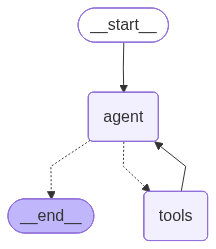

In [10]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) overview",                                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: d8e849c0-e2b1-405b-9d88-dc226d8fe0fa                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) overview', 'status': 'pending'}]       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: 8cfe825a-042a-48f5-95a1-4165acc03436                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol MCP overview':                                                 │
│                                                                                                                 │
│ - URL_error_Hk1nsxJ-.md: *   [Concepts of                                                                       │
│ MCP](https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp) This overview of the Model     │
│ Context Protocol (MCP) discusses its (https://modelcontextprotocol.io/docs/concepts/architecture#scope) and     │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp), and provides an                   │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#example) demonstrating each core concept.Because    │
│ MCP SDKs abstract away many concerns, most developers will likely find the                                      │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#data-layer-protocol) section to be the most useful. │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp) ####                             │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#data-layer) ####                                  │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#transport-layer) ###                              │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#data-layer-protocol) Developers will likely find  │
│ the data layer — in particular, the set of                                                                      │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#primitives) — to be the most interesting part of    │
│ MCP. It can expose tools for querying the database, a resource that contains the schema of the database, and a  │
│ prompt that includes few-shot examples for interacting with the tools.For more details about server primitives  │
│ see (https://modelcontextprotocol.io/docs/concepts/server-concepts).MCP also defines primitives that _clients_  │
│ can expose....                                                                                                  │
│                                                                                                                 │
│ Files: URL_error_Hk1nsxJ-.md                                                                                    │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "URL_error_Hk1nsxJ-.md",                                                                         │
│   "limit": 2000,                                                                                                │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: 83e0362c-9d50-4516-8ab7-2b2e73e46445                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: Architecture overview - Model Context Protocol                                         │
│      2                                                                                                          │
│      3  **URL:** https://modelcontextprotocol.io/docs/concepts/architecture                                     │
│      4  **Query:** Model Context Protocol MCP overview                                                          │
│      5  **Date:** Mon Sep 29, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  *   [Concepts of MCP](https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp) This  │
│ overview of the Model Context Protocol (MCP) discusses its                                                      │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#scope) and                                          │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp), and provides an                   │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#example) demonstrating each core concept.Because    │
│ MCP SDKs abstract away many concerns, most developers will likely find the                                      │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#data-layer-protocol) section to be the most useful. │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#concepts-of-mcp) ####                             │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#data-layer) ####                                  │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#transport-layer) ###                              │
│ [​](https://modelcontextprotocol.io/docs/concepts/architecture#data-layer-protocol) Developers will likely find  │
│ the data layer — in particular, the set of                                                                      │
│ (https://modelcontextprotocol.io/docs/concepts/architecture#primitives) — to be the most interesting part of    │
│ MCP. It can expose tools for querying the database, a resource that contains the schema of the database, and a  │
│ prompt that includes few-shot examples for interacting with the tools.For more details about server primitives  │
│ see (https://modelcontextprotocol.io/docs/concepts/server-concepts).MCP also defines primitives that _clients_  │
│ can expose.                                                                                                     │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  Architecture overview - Model Context Protocol                                                          │
│     12                                                                                                          │
│     13  ===============                                                                                         │
│     14                                                                                                          │
│     15  [Model Context Protocol home page![Image 1: light                                                       │
│ logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/light.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=449 │
│ 8cb8a57d574005f3dca62bdd49c95)![Image 2: dark                                                                   │
│ logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ **`tools/list` (request)**                                                                                      │
│ - Sent by a client after the connection is initialized.                                                         │
│ - It is a normal JSON‑RPC **request** (has an `id`).                                                            │
│ - The server replies with the current list of tools.                                                            │
│ - The client uses this to discover what tools are available.                                                    │
│                                                                                                                 │
│ **`notifications/tools/list_changed` (notification)**                                                           │
│ - Sent by a server **proactively** when its tool set changes.                                                   │
│ - It is a JSON‑RPC **notification** (no `id` field).                                                            │
│ - No response is expected; the client simply reacts to the event.                                               │
│ - The client usually follows up by sending a `tools/list` request to refresh the list.                          │
│                                                                                                                 │
│ So, `tools/list` is a *client‑initiated* request to fetch the tool list, while                                  │
│ `notifications/tools/list_changed` is a *server‑initiated* event that tells the client the list has changed and │
│ that it should refresh it.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

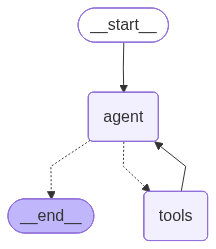

In [12]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "description": "Research Model Context Protocol (MCP) and summarize briefly",                             │
│       "id": "1",                                                                                                │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 63cd37e0-e494-4949-884d-f095cea5733b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for write_todos                                                                       │
│ todos.0.content                                                                                                 │
│   Field required                                                                                                │
│     For further information visit https://errors.pydantic.dev/2.11/v/missing                                    │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) and summarize briefly",                                 │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 2c44a21e-faa6-4f23-9a5c-a3e007c16ca1                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) and summarize briefly', 'status':      │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP"                                                                         │
│ }                                                                                                               │
│    ID: 918f371b-0888-4261-984c-8a96d427c377                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol MCP':                                                          │
│                                                                                                                 │
│ - mcp_protocol_overview_4kiwqDMS.md: The text introduces the Model Context Protocol (MCP), a standard for       │
│ integrating tools with large language models (LLMs). It outlines MCP's architecture, key components like        │
│ resources, tools, and prompts, and its role in enabling autonomous AI agents. Key points include MCP's          │
│ potential to streamline agentic workflows and enhance LLM capabilities through standardized context sharing.... │
│                                                                                                                 │
│ Files: mcp_protocol_overview_4kiwqDMS.md                                                                        │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_protocol_overview_4kiwqDMS.md",                                                             │
│   "limit": 200,                                                                                                 │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: e084aaa7-6b5b-4e9f-a1a0-5f4b3dd746c8                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: What is Model Context Protocol (MCP)?                                                  │
│      2                                                                                                          │
│      3  **URL:** https://www.ibm.com/think/topics/model-context-protocol                                        │
│      4  **Query:** Model Context Protocol MCP                                                                   │
│      5  **Date:** Mon Sep 29, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  The text introduces the Model Context Protocol (MCP), a standard for integrating tools with large       │
│ language models (LLMs). It outlines MCP's architecture, key components like resources, tools, and prompts, and  │
│ its role in enabling autonomous AI agents. Key points include MCP's potential to streamline agentic workflows   │
│ and enhance LLM capabilities through standardized context sharing.                                              │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  What is Model Context Protocol (MCP)? | IBM                                                             │
│     12                                                                                                          │
│     13                                                                                                          │
│     14                                                                                                          │
│     15                                                                                                          │
│     16                                                                                                          │
│     17  What is Model Context Protocol (MCP)?                                                                   │
│     18  =====================================                                                                   │
│     19                                                                                                          │
│     20  ![Graphic render showcasing a twist of structured and unstructured data with                            │
│ watsonx.data](/content/dam/worldwide-content/creative-assets/ibs/ul/cci/67/7e/ibm_think_projectkavya_twist_stil │
│ l_4k.component.xl.ts=1758059812760.png/content/adobe-cms/us/en/think/topics/model-context-protocol/_jcr_content │
│ /root/leadspace_container/leadspace_banner)                                                                     │
│     21                                                                                                          │
│     22  AI Agents                                                                                               │
│     23                                                                                                          │
│     24  * [Welcome](https://www.ibm.com/think/ai-agents#605511093)                                              │
│     25  * Caret right                                                                                           │
│     26    Introduction                                                                                          │
│     27    + [Overview](https://www.ibm.com/think/topics/ai-agents#7281535)                                      │
│     28    + [AI agents vs AI assistants](https://www.ib

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I’m ready to help! What would you like to explore or discuss today?                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->